In [1]:
%run imports/VacuumGauge_functions.ipynb
%run imports/rbflayer.py

import pandas as pd
import numpy as np
import joblib
import tensorflow as tf
from tensorflow import keras

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#machine learning
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans

#signal processing
import scipy
from skimage.measure import block_reduce

import warnings
warnings.filterwarnings('ignore')


root_logdir = os.path.join(os.curdir, 'data/logs')

if not(os.path.exists(root_logdir)):
    !mkdir -p {root_logdir}
    print('{} succesfully created.'.format(root_logdir))
else:
    print('{} already exist.'.format(root_logdir))

def get_run_logdir(model_version):
    import time
    run_id = time.strftime('{}_run_%Y_%m_%d-%H_%M_%S'.format(model_version))
    return os.path.join(root_logdir, run_id)

./data/logs already exist.


### Tensorboard starting -- (only if needed)

In [25]:
%load_ext tensorboard
%tensorboard --logdir={root_logdir} --port=6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Reading the dataset

- df_ok: labels of ok gauges
- df_delta: labels of delta gauges
- df_ raw: raw data cointaining the full reading of each gauge

In [2]:
df_delta = pd.read_csv('data/datasets/df_delta.csv') # cointains labels for delta VG
df_ok = pd.read_csv('data/datasets/df_ok.csv')  #contains labels for ok VG

df_raw = pd.read_csv('data/datasets/df_raw.csv') ## contains full reading of each VG

df_labels = pd.concat([df_ok, df_delta], sort=False, axis=0)


df_VG = pd.merge(df_raw, df_labels, on =['gauge_id','fillNumber'])
df_VG = df_VG.set_index(['gauge_id','fillNumber'], drop=True)

## Removing categorical values
df_VG.y.replace(to_replace=['ok', 'delta'], value=[0, 1], inplace=True)

## Splitting the dataset in input and target
- X are the input features
- y is the target vector

Definition of a StratifiedKFold split to be used in all the grid searchs for all the model: 

In [3]:
X = np.array(df_VG.iloc[:, :-1])
y = np.array(df_VG.iloc[:, -1])

from sklearn.model_selection import StratifiedShuffleSplit


sss = StratifiedShuffleSplit(n_splits=10, test_size=0.33, random_state=42)


## Hold out a test set for final evaluation

In [ ]:
# from sklearn.model_selection import StratifiedShuffleSplit


# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# print(sss)

# for train_index, test_index in sss.split(X, y):
#     print("TRAIN size:", len(train_index), "TEST size:", len(test_index))
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]


# print(len(y_train))
# print(sum(y_train))
# print(len(y_test))
# print(sum(y_test))

## Preprocessing

The preprocessing of the input is divided in 3 steps:

1. Max pooling layer with kernel 15 and strides 15: reduce the dimensionality of a factor 15 keeping the max values, it preserve the interesting part of the signal
2. Median filter with kernel 9 to get rid of evenutally present white noise
3. Savitzky–Golay filter to further reduce discontinuities
4. Scaling of each time series to help gradient descent converge

In [16]:
import scipy
from skimage.measure import block_reduce


## Tensorflow implementation of max_pool

# X_max = X.reshape((X.shape[0], 3000, 1))  
# X_max = tf.nn.max_pool1d(X_max, ksize=15, strides=15, padding='VALID')
# X_max = X_max[...,0]

## Numpy implementation of max_pool

X_max = block_reduce(X, block_size=(1,15), func=np.max)


X_med = np.apply_along_axis(scipy.signal.medfilt, axis=1, arr= X_max, kernel_size=9)
X_sav = np.apply_along_axis(scipy.signal.savgol_filter, axis=1,
                            arr= X_med, window_length=11, polyorder=2)
scaler = RowScaler(scaling_method='Standard')

pca = PCA(n_components=30)
X_norm = scaler.fit_transform(X_sav)
X_pca = pca.fit_transform(X_norm)



# X_f = np.fft.fft(X_avg, X_avg.shape[-1])
# X_f = np.fft.fftshift(X_f, axes=-1)
X_pca.shape

(278, 30)

In [17]:
# g = np.gradient(X_norm, axis=1)
# for i in range(0, 20, 1):
#     plt.plot(X_norm[i])
#     plt.plot(g[i]/np.max(g[i]))
#     plt.show()

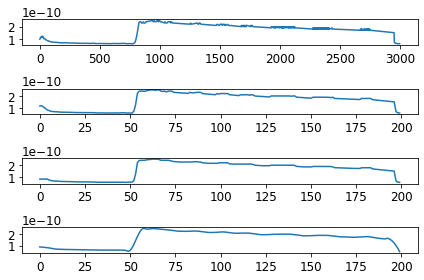

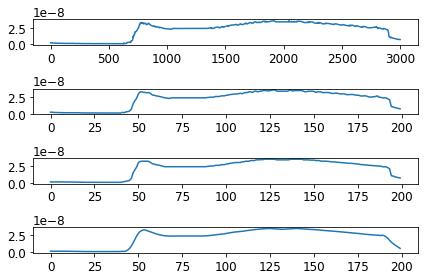

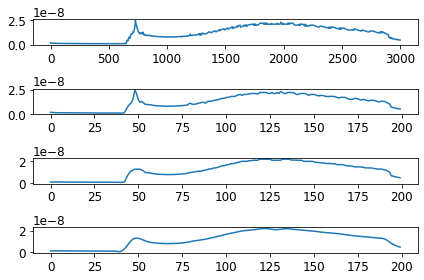

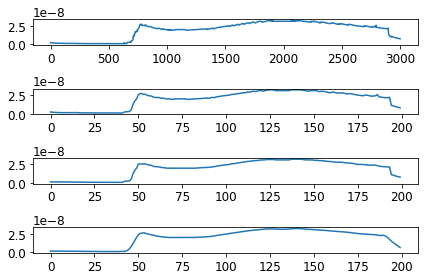

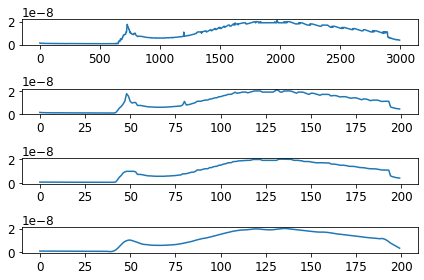

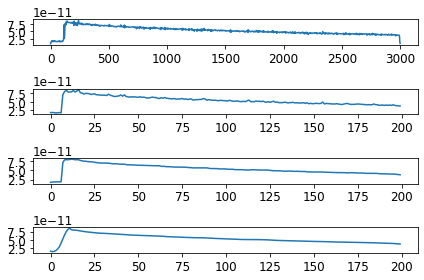

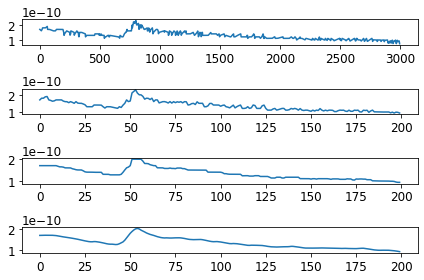

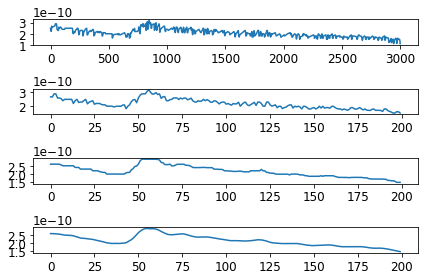

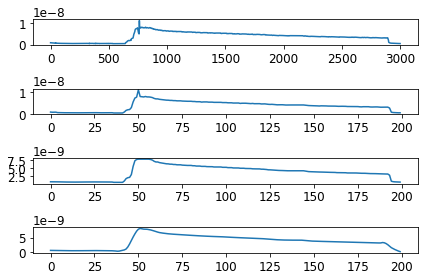

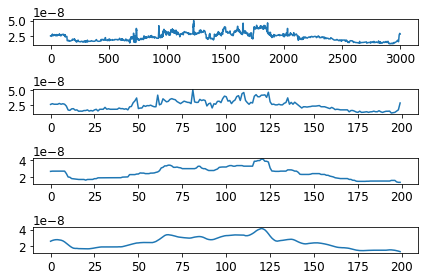

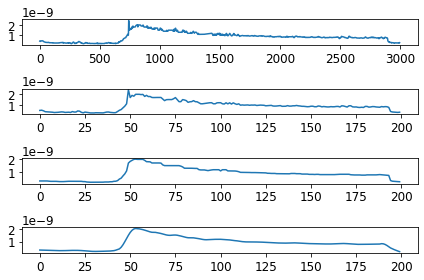

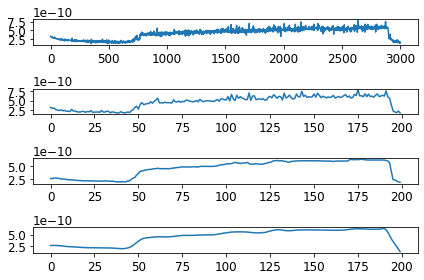

In [18]:
%matplotlib inline
for i in range(0,12):
    plt.subplot(4,1,1)
    plt.plot(X[i])
    plt.subplot(4,1,2)
    plt.plot(X_max[i])
    plt.subplot(4,1,3)
    plt.plot(X_med[i])
    plt.subplot(4,1,4)
    plt.plot(X_sav[i])
    plt.tight_layout()
    plt.show()

## Quick overview on the PCA impact

PCA performed on the trainig part of the normalised dataset to visualize its impact.

In [ ]:
scaler = RowScaler('Standard')
# X_norm = scaler.fit_transform(X)
# X_norm[0].shape

i=100
X_m = scaler.fit_transform(X) - scaler.fit_transform(X).mean(axis=0, keepdims=0)
plt.figure()
plt.plot(range(3000), scaler.fit_transform(X)[i])
plt.plot(range(3000), X_m[i])
plt.show()

In [ ]:
preprocess = Prepocess(log_scale=False)
scaler = RowScaler('Standard')

pca = PCA(n_components=3)

X_pca = pca.fit_transform(scaler.fit_transform(preprocess.fit_transform(X)))
# X_pca = pca.fit_transform(scaler.fit_transform(X))
X_pca[1]

In [ ]:
%matplotlib inline

fontsize=15

ok = X_pca[y==0]
delta = X_pca[y ==1]


plt.style.use('seaborn-whitegrid')
fontsize=20

plt.figure(figsize=(10,8))
plt.scatter(ok[:,0], ok[:,1], c='b', label='no heating', s=50)
plt.scatter(delta[:,0], delta[:,1], c='r', label='heating', s=50)

plt.legend(fontsize=fontsize)
plt.xlabel('component #1', fontsize=fontsize)
plt.ylabel('component #2', fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.grid(True)
plt.show()

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(10,8))
ax = Axes3D(fig)

ax.scatter(ok[:,0], ok[:,1], ok[:,2], c='b', label='no heating', s=50)
ax.scatter(delta[:,0], delta[:,1], delta[:,2], c='r', label='heating', s=50)

ax.set_xlabel('component #1', fontsize=fontsize)
ax.set_ylabel('component #2', fontsize=fontsize)
ax.set_zlabel('component #3', fontsize=fontsize)

# ax.set_xlim(-25,30)
# ax.set_ylim(-5,20)
# ax.set_zlim(-10,7.5)
plt.gca().patch.set_facecolor('white')
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()


In [ ]:
index = np.where(np.all([y == 1, X_pca[:,0]>5], axis=0))

## K-MEANS preprocessing

In [15]:
from sklearn.decomposition import KernelPCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import TSNE

preprocess = Prepocess(log_scale=False)
scaler = RowScaler('Standard')

kmeans = KMeans(n_clusters=3,
                algorithm='elkan',
                random_state=42)
# lle = LocallyLinearEmbedding(n_components=3, n_neighbors= 10)
# rbf_pca = KernelPCA(n_components=3, kernel='rbf', gamma=0.005)
# tsne = TSNE(n_components=3, perplexity=20)
a = preprocess.fit_transform(X)
b = scaler.fit_transform(a)
d = kmeans.fit_transform(X_norm)
# d = rbf_pca.fit_transform(c)

In [16]:
d.shape

(278, 3)

In [17]:
# for center in kmeans.cluster_centers_:
#     plt.plot(range(200), center)
#     plt.show()

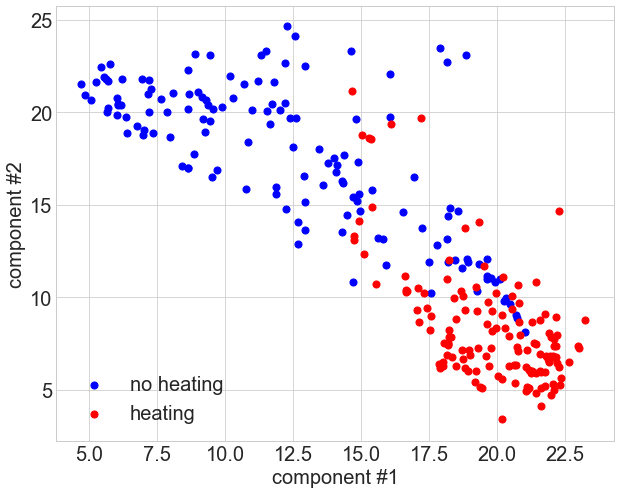

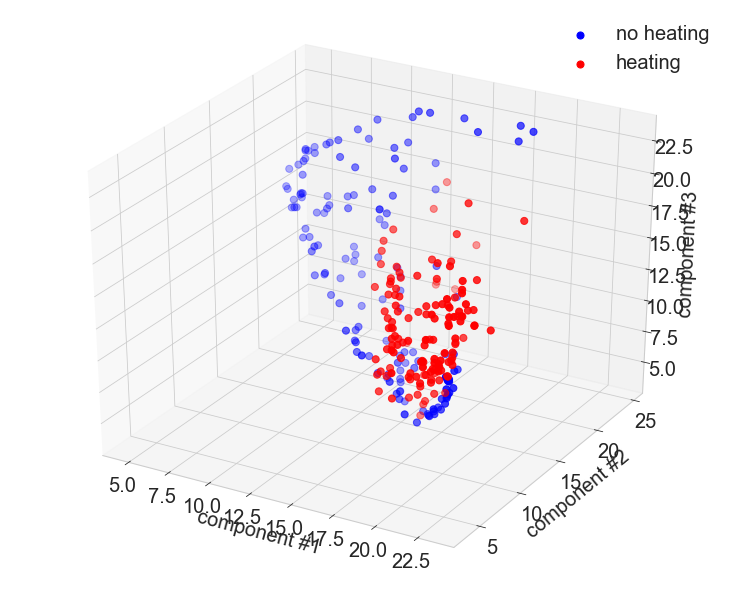

In [19]:
%matplotlib inline
ok = d[y==0]
delta = d[y ==1]


plt.style.use('seaborn-whitegrid')
fontsize=20
plt.close('all')
plt.figure(figsize=(10,8))
plt.scatter(ok[:,0], ok[:,1], c='b', label='no heating', s=50)
plt.scatter(delta[:,0], delta[:,1], c='r', label='heating', s=50)

plt.legend(fontsize=fontsize)
plt.xlabel('component #1', fontsize=fontsize)
plt.ylabel('component #2', fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.grid(True)
plt.show()

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(10,8))
ax = Axes3D(fig)

ax.scatter(ok[:,0], ok[:,1], ok[:,2], c='b', label='no heating', s=50)
ax.scatter(delta[:,0], delta[:,1], delta[:,2], c='r', label='heating', s=50)

ax.set_xlabel('component #1', fontsize=fontsize)
ax.set_ylabel('component #2', fontsize=fontsize)
ax.set_zlabel('component #3', fontsize=fontsize)

# ax.set_xlim(-25,30)
# ax.set_ylim(-5,20)
# ax.set_zlim(-10,7.5)
plt.gca().patch.set_facecolor('white')
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.legend(fontsize=fontsize)
plt.tight_layout()
plt.show()

## Random Forest

In [92]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = Pipeline([
    ('preprocessor', Prepocess()),
    ('scaler', RowScaler(scaling_method='Standard')),
    ('kmeans', KMeans(algorithm='elkan',random_state=42)),
    ('forest', RandomForestClassifier())

])

model = forest_clf
model_dir = 'data/models/random_forest'
model_version = 'forest_007.pkl'
scoring = ['recall', 'accuracy', 'precision']

forest_path = os.path.join(model_dir, model_version)

print(os.path.join(model_dir,model_version))

data/models/random_forest/forest_007.pkl


#### GridSearch

In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
a = Real(2,100, prior='log-uniform')
# b = Real(1,100)
X = range(1,1000)
plt.plot((sorted(a.rvs(100))))
# plt.plot(sorted(b.rvs(1000)))
print(np.max(a.transform(X)))

In [ ]:
list(range(30,51, 10))

In [93]:
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

param_grid = [
    {
    #  'scaler__scaling_method': RowScaler().scaling_options,
     'kmeans__n_clusters': [10, 30, 100],
     'preprocessor__log_scale': [False],
     'forest__n_estimators': [50, 80, 100],
     'forest__max_leaf_nodes': [2, 3, 4],
     'forest__bootstrap': [False],
    }
]


In [94]:
print("# Tuning hyper-parameters for {} and {}".format(scoring[0], scoring[1]))
print()
grid_search = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
    scoring=scoring,
    n_jobs=-1,
    verbose=1, 
    cv=sss, 
    return_train_score=True,
    refit=scoring[1]  ## Score used for final refit
)

grid_search.fit(X, y)

# Tuning hyper-parameters for recall and accuracy

Fitting 10 folds for each of 27 candidates, totalling 270 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  3.5min finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.33,
            train_size=None),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        Prepocess(log_scale=False,
                                                  max_pool_size=15,
                                                  median_size=9,
                                                  savgol_length=11)),
                                       ('scaler',
                                        RowScaler(scaling_method='Standard')),
                                       ('kmeans',
                                        KMeans(algorithm='elkan', copy_x...
                                                               warm_start=False))],
                                verbose=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'forest__bootstrap'

In [95]:
printGridSearchResults(grid_search, scoring[0])

Best parameters set found on development set:
{'forest__bootstrap': False, 'forest__max_leaf_nodes': 4, 'forest__n_estimators': 50, 'kmeans__n_clusters': 30, 'preprocessor__log_scale': False}

Grid scores on development set:

0.900 (+/-0.083) for {'forest__bootstrap': False, 'forest__max_leaf_nodes': 2, 'forest__n_estimators': 50, 'kmeans__n_clusters': 10, 'preprocessor__log_scale': False}
0.907 (+/-0.093) for {'forest__bootstrap': False, 'forest__max_leaf_nodes': 2, 'forest__n_estimators': 50, 'kmeans__n_clusters': 30, 'preprocessor__log_scale': False}
0.902 (+/-0.065) for {'forest__bootstrap': False, 'forest__max_leaf_nodes': 2, 'forest__n_estimators': 50, 'kmeans__n_clusters': 100, 'preprocessor__log_scale': False}
0.893 (+/-0.079) for {'forest__bootstrap': False, 'forest__max_leaf_nodes': 2, 'forest__n_estimators': 80, 'kmeans__n_clusters': 10, 'preprocessor__log_scale': False}
0.896 (+/-0.111) for {'forest__bootstrap': False, 'forest__max_leaf_nodes': 2, 'forest__n_estimators': 80

In [96]:
grid_search.best_score_

0.9478260869565217

### Saving the model

In [97]:
save_model(grid_search, model_dir, model_version)

data/models/random_forest/forest_007.pkl succesfully saved.


## Logistic Regressor (classifier)

In [4]:
from sklearn.linear_model import LogisticRegression

log_clf = Pipeline([
    ('preprocessor', Prepocess(log_scale=False)),
    ('scaler', RowScaler(scaling_method='Standard')),
    ('kmeans', KMeans(algorithm='elkan',random_state=42)),
    ('logistic', LogisticRegression(solver='liblinear'))

])

model = log_clf
model_dir = 'data/models/logistic_classifier'
model_version = 'logistic_005.pkl'
scoring = ['recall', 'accuracy', 'precision']

log_path = os.path.join(model_dir, model_version)

print(os.path.join(model_dir, model_version))

data/models/logistic_classifier/logistic_005.pkl


In [5]:
param_grid = [
    {
    #  'scaler__scaling_method': RowScaler().scaling_options,
     'kmeans__n_clusters': [5, 10, 30, 50, 100],
     'logistic__penalty': ['l1', 'l2']
    }
]

In [6]:
print("# Tuning hyper-parameters for {} and {}".format(scoring[0], scoring[1]))
print()
grid_search = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
    scoring=scoring,
    n_jobs=-1,
    verbose=1, 
    cv=sss, 
    return_train_score=True,
    refit=scoring[0]  ## Score used for final refit
)

grid_search.fit(X, y)

# Tuning hyper-parameters for recall and accuracy

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.33,
            train_size=None),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        Prepocess(log_scale=False,
                                                  max_pool_size=15,
                                                  median_size=9,
                                                  savgol_length=11)),
                                       ('scaler',
                                        RowScaler(scaling_method='Standard')),
                                       ('kmeans',
                                        KMeans(algorithm='elkan', copy_x...
                                                           multi_class='warn',
                                                           n_jobs=None,
                                                           pen

In [7]:
printGridSearchResults(grid_search, scoring[2])

Best parameters set found on development set:
{'kmeans__n_clusters': 30, 'logistic__penalty': 'l2'}

Grid scores on development set:

0.945 (+/-0.050) for {'kmeans__n_clusters': 5, 'logistic__penalty': 'l1'}
0.949 (+/-0.039) for {'kmeans__n_clusters': 5, 'logistic__penalty': 'l2'}
0.954 (+/-0.041) for {'kmeans__n_clusters': 10, 'logistic__penalty': 'l1'}
0.956 (+/-0.026) for {'kmeans__n_clusters': 10, 'logistic__penalty': 'l2'}
0.967 (+/-0.040) for {'kmeans__n_clusters': 30, 'logistic__penalty': 'l1'}
0.965 (+/-0.047) for {'kmeans__n_clusters': 30, 'logistic__penalty': 'l2'}
0.975 (+/-0.037) for {'kmeans__n_clusters': 50, 'logistic__penalty': 'l1'}
0.980 (+/-0.024) for {'kmeans__n_clusters': 50, 'logistic__penalty': 'l2'}
0.980 (+/-0.037) for {'kmeans__n_clusters': 100, 'logistic__penalty': 'l1'}
0.982 (+/-0.038) for {'kmeans__n_clusters': 100, 'logistic__penalty': 'l2'}


In [8]:
grid_search.best_estimator_

Pipeline(memory=None,
         steps=[('preprocessor',
                 Prepocess(log_scale=False, max_pool_size=15, median_size=9,
                           savgol_length=11)),
                ('scaler', RowScaler(scaling_method='Standard')),
                ('kmeans',
                 KMeans(algorithm='elkan', copy_x=True, init='k-means++',
                        max_iter=300, n_clusters=30, n_init=10, n_jobs=None,
                        precompute_distances='auto', random_state=42,
                        tol=0.0001, verbose=0)),
                ('logistic',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='liblinear', tol=0.0001, verbose

### Saving the model

In [9]:
#print(grid_search)
save_model(grid_search, model_dir, model_version)

data/models/logistic_classifier/logistic_005.pkl succesfully saved.


## SVM

In [56]:
from sklearn.svm import SVC

svm_clf = Pipeline([
    ('preprocessor', Prepocess()),
    ('scaler', RowScaler(scaling_method='Standard')),
    ('kmeans', KMeans(algorithm='elkan',random_state=42)),
    ('svm', SVC())

])

model = svm_clf
model_dir = 'data/models/svm'
model_version = 'svm_004.pkl'
scoring = ['recall', 'accuracy', 'precision']

svm_path = os.path.join(model_dir, model_version)
print(os.path.join(model_dir, model_version))

data/models/svm/svm_004.pkl


In [57]:
param_grid = [
    {'svm__kernel': ['linear'],
     'svm__random_state': [42],
     'svm__C' : np.logspace(0.1, 3, 5, endpoint=True),
     'kmeans__n_clusters': [5, 10, 30],
    }
]

In [58]:
print("# Tuning hyper-parameters for {} and {}".format(scoring[0], scoring[1]))
print()
grid_search = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
    scoring=scoring,
    n_jobs=-1,
    verbose=1, 
    cv=sss, 
    return_train_score=True,
    refit=scoring[0]  ## Score used for final refit
)

grid_search.fit(X, y)

# Tuning hyper-parameters for recall and accuracy

Fitting 10 folds for each of 15 candidates, totalling 150 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.2min finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.33,
            train_size=None),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        Prepocess(log_scale=False,
                                                  max_pool_size=15,
                                                  median_size=9,
                                                  savgol_length=11)),
                                       ('scaler',
                                        RowScaler(scaling_method='Standard')),
                                       ('kmeans',
                                        KMeans(algorithm='elkan', copy_x...
                                            random_state=None, shrinking=True,
                                            tol=0.001, verbose=False))],
                                verbose=False),
             

In [35]:
printGridSearchResults(grid_search, scoring[0])
printGridSearchResults(grid_search, scoring[1])
printGridSearchResults(grid_search, scoring[2])

Best parameters set found on development set:
{'svm__kernel': 'linear', 'svm__random_state': 42}

Grid scores on development set:

0.937 (+/-0.063) for {'svm__kernel': 'linear', 'svm__random_state': 42}
Best parameters set found on development set:
{'svm__kernel': 'linear', 'svm__random_state': 42}

Grid scores on development set:

0.937 (+/-0.035) for {'svm__kernel': 'linear', 'svm__random_state': 42}
Best parameters set found on development set:
{'svm__kernel': 'linear', 'svm__random_state': 42}

Grid scores on development set:

0.938 (+/-0.046) for {'svm__kernel': 'linear', 'svm__random_state': 42}


In [59]:
save_model(grid_search, model_dir, model_version)

data/models/svm/svm_004.pkl succesfully saved.


## KNN

In [10]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = Pipeline([
    ('preprocessor', Prepocess()),
    ('scaler', RowScaler(scaling_method='Standard')),
    ('kmeans', KMeans(algorithm='elkan',random_state=42)),
    ('knn', KNeighborsClassifier())

])

model = knn_clf
model_dir = 'data/models/knn'
model_version = 'knn_004.pkl'
scoring = ['recall', 'accuracy', 'precision']

knn_path = os.path.join(model_dir, model_version)
print(os.path.join(model_dir, model_version))

data/models/knn/knn_004.pkl


In [11]:
param_grid = [
    {'scaler__scaling_method': RowScaler().scaling_options,
     'kmeans__n_clusters': [5, 10, 30, 50, 100],
     'knn__n_neighbors': range(3,7),
     'knn__n_jobs': [-1]
    }
]

In [12]:
print("# Tuning hyper-parameters for {} and {}".format(scoring[0], scoring[1]))
print()
grid_search = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
    scoring=scoring,
    n_jobs=-1,
    verbose=1, 
    cv=sss, 
    return_train_score=True,
    refit=scoring[0]  ## Score used for final refit
)

grid_search.fit(X, y)

# Tuning hyper-parameters for recall and accuracy

Fitting 10 folds for each of 80 candidates, totalling 800 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   47.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  9.8min finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.33,
            train_size=None),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        Prepocess(log_scale=False,
                                                  max_pool_size=15,
                                                  median_size=9,
                                                  savgol_length=11)),
                                       ('scaler',
                                        RowScaler(scaling_method='Standard')),
                                       ('kmeans',
                                        KMeans(algorithm='elkan', copy_x...
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                                verbose=False),
 

In [13]:
printGridSearchResults(grid_search, scoring[1])

Best parameters set found on development set:
{'kmeans__n_clusters': 10, 'knn__n_jobs': -1, 'knn__n_neighbors': 3, 'scaler__scaling_method': 'Standard'}

Grid scores on development set:

0.951 (+/-0.031) for {'kmeans__n_clusters': 5, 'knn__n_jobs': -1, 'knn__n_neighbors': 3, 'scaler__scaling_method': 'Standard'}
0.961 (+/-0.029) for {'kmeans__n_clusters': 5, 'knn__n_jobs': -1, 'knn__n_neighbors': 3, 'scaler__scaling_method': 'MinMax'}
0.910 (+/-0.034) for {'kmeans__n_clusters': 5, 'knn__n_jobs': -1, 'knn__n_neighbors': 3, 'scaler__scaling_method': 'MaxAbs'}
0.945 (+/-0.055) for {'kmeans__n_clusters': 5, 'knn__n_jobs': -1, 'knn__n_neighbors': 3, 'scaler__scaling_method': 'Robust'}
0.943 (+/-0.035) for {'kmeans__n_clusters': 5, 'knn__n_jobs': -1, 'knn__n_neighbors': 4, 'scaler__scaling_method': 'Standard'}
0.953 (+/-0.034) for {'kmeans__n_clusters': 5, 'knn__n_jobs': -1, 'knn__n_neighbors': 4, 'scaler__scaling_method': 'MinMax'}
0.921 (+/-0.034) for {'kmeans__n_clusters': 5, 'knn__n_jobs

In [14]:
grid_search.best_score_

0.95

In [15]:
save_model(grid_search, model_dir, model_version)

data/models/knn/knn_004.pkl succesfully saved.


## CNN 

In [ ]:
Calcolare false positive rate sui casi non labellati
provare la derivata ed eventualmente lstm con 2 input (derivata e segnale)

Function that builds the CNN for the gridsearch. Each layer is a Conv1D and a maxpool. Each layer reduce the second axis dimension of a factor 2.

In [3]:
%run imports/VacuumGauge_functions.ipynb
keras.backend.clear_session()

METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall')
]

def build_CNN(layers=2, filters=10, kernel_size=50, metrics=METRICS):
    
    model = keras.models.Sequential()
    model.add(keras.layers.Reshape((3000, 1), input_shape=[3000]))
    model.add(keras.layers.MaxPool1D(pool_size=15, strides=15, padding='same'))
    # model.add(keras.layers.Lambda(lambda X: preprocess(X)))
    model.add(KerasPreprocess())

    for layer in range(layers):
        model.add(keras.layers.Conv1D(filters=filters, kernel_size=kernel_size,
                                      activation='relu', strides=1, input_shape = [None, 1],
                                      padding='same', use_bias=True, kernel_initializer='he_normal',
                                      ))
        model.add(keras.layers.MaxPool1D(pool_size=2, padding='same'))

    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(units=1, activation='sigmoid'))

    # learning_rate = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.1,
    #                                                             decay_steps= batch_size ,
    #                                                             decay_rate=0.1)
    optimizer = keras.optimizers.Nadam(learning_rate=1e-5)

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=metrics)
    return model

model = build_CNN(layers=2, filters=10, kernel_size=50)
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 3000, 1)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 200, 1)            0         
_________________________________________________________________
keras_preprocess (KerasPrepr (None, 200, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 200, 10)           510       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 100, 10)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 10)           5010      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 50, 10)            0

In [174]:
model = build_CNN(layers=2, filters=10, kernel_size=50)
epochs = 300
run_log_dir = get_run_logdir('cnn')
tensorboard_cb = keras.callbacks.TensorBoard(run_log_dir)
#model.run_eagerly = False

print(sss)

for index, (train_index, test_index) in enumerate(sss.split(X, y)):


    print('Iteration {} of {}'.format(index + 1, sss.get_n_splits()))

    X_train, X_test = tf.constant(X[train_index], dtype='float32'), tf.constant(X[test_index], dtype='float32')
    y_train, y_test = tf.constant(y[train_index], dtype='float32'), tf.constant(y[test_index], dtype='float32')

    model = build_CNN(layers=2, filters=10, kernel_size=50)
    history = model.fit(X_train, y_train,
                        epochs=epochs, verbose=0, batch_size=32,
                        validation_data=(X_test, y_test))
    if index == 0:
        results = {item: [] for item in history.history}

    for key in history.history.keys():
        results[key].append(history.history[key][-1])



StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.33,
            train_size=None)
Iteration 1 of 10
Iteration 2 of 10
Iteration 3 of 10
Iteration 4 of 10
Iteration 5 of 10
Iteration 6 of 10
Iteration 7 of 10
Iteration 8 of 10
Iteration 9 of 10
Iteration 10 of 10


In [175]:
for key in results.keys():
    print('{} = {:.2f} +/- {:.2f}'.format(key, np.mean(results[key]), np.std(results[key])))

loss = 0.11 +/- 0.03
accuracy = 0.97 +/- 0.01
precision = 0.98 +/- 0.02
recall = 0.96 +/- 0.02
val_loss = 0.15 +/- 0.04
val_accuracy = 0.95 +/- 0.02
val_precision = 0.96 +/- 0.03
val_recall = 0.94 +/- 0.03


#### Refit on full data-set and save

In [8]:
epochs = 300
model = build_CNN(layers=2, filters=10, kernel_size=50)
history = model.fit(X, y, epochs=epochs, verbose=1, batch_size=32)

Epoch 1/300
9/9 [==============================] - 0s 26ms/step - loss: 0.5706 - accuracy: 0.7770 - precision: 0.7550 - recall: 0.8201
Epoch 2/300
9/9 [==============================] - 0s 26ms/step - loss: 0.5591 - accuracy: 0.7842 - precision: 0.7582 - recall: 0.8345
Epoch 3/300
9/9 [==============================] - 0s 28ms/step - loss: 0.5469 - accuracy: 0.7914 - precision: 0.7613 - recall: 0.8489
Epoch 4/300
9/9 [==============================] - 0s 26ms/step - loss: 0.5340 - accuracy: 0.7986 - precision: 0.7677 - recall: 0.8561
Epoch 5/300
9/9 [==============================] - 0s 25ms/step - loss: 0.5218 - accuracy: 0.8201 - precision: 0.7764 - recall: 0.8993
Epoch 6/300
9/9 [==============================] - 0s 26ms/step - loss: 0.5101 - accuracy: 0.8237 - precision: 0.7778 - recall: 0.9065
Epoch 7/300
9/9 [==============================] - 0s 28ms/step - loss: 0.4986 - accuracy: 0.8345 - precision: 0.7818 - recall: 0.9281
Epoch 8/300
9/9 [==============================] - 0s 2

In [9]:
model_dir = 'data/models/cnn'
model_version = 'cnn_005.h5'
model_csv = 'cnn_005.csv'

cv_result = pd.DataFrame(results)
cv_result.to_csv(os.path.join(model_dir, model_csv),  index=False)
model.save(os.path.join(model_dir, model_version))

In [173]:
for key in cv_result:
    print('{} = {:.2f} +/- {:.2f}'.format(key, np.mean(results[key]), np.std(results[key])))

loss = 0.10 +/- 0.03
accuracy = 0.97 +/- 0.01
precision = 0.98 +/- 0.01
recall = 0.96 +/- 0.01
val_loss = 0.14 +/- 0.04
val_accuracy = 0.96 +/- 0.02
val_precision = 0.96 +/- 0.02
val_recall = 0.95 +/- 0.02


In [ ]:
#early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch/s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=1e-5, s=-17)    
epochs = 500
run_log_dir = get_run_logdir('cnn')
tensorboard_cb = keras.callbacks.TensorBoard(run_log_dir)  

lr = [exponential_decay_fn(epoch) for epoch in range(100)]
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
epochs = 100
class_weight = {0: 1.,
                1: 1.}
history = model.fit(X_train, y_train,
                    epochs=epochs, verbose=1, class_weight=class_weight,
                    validation_data=(X_test, y_test),
                    callbacks= [lr_scheduler, tensorboard_cb])

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(lr, history.history['val_loss'])
plt.xlim(1e-5, 1e-1)
plt.xscale('log')
plt.show()

## RBF

In [5]:
df_raw = pd.read_csv('data/datasets/df_raw.csv')
df_raw = df_raw[df_raw.fillNumber != 2011]

df_raw = df_raw.astype({'fillNumber': 'int'})
df_raw = df_raw.set_index(['gauge_id','fillNumber'], drop=True)
df_raw.index.get_level_values('fillNumber').value_counts()
# df_raw.drop(index=df_VG.index, inplace=True) #5650- 278

kmeans_centers_path = 'data/datasets/k12_centers.npy'
silhouette_scores_path = 'data/datasets/silhouette_scores_range_2_20.npy'
inertias_path = 'data/datasets/intertias_range_2_20.npy'

In [55]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


scaler = RowScaler(scaling_method='Standard')

X_max = block_reduce(df_raw, block_size=(1, 15), func=np.max)

X_med = np.apply_along_axis(scipy.signal.medfilt,
                            axis=1,
                            arr= X_max,
                            kernel_size=9)



X_scaled = scaler.fit_transform(X_med)

In [110]:
if os.path.exists(kmeans_centers_path):
    k12_centers = np.load(kmeans_centers_path)
    print('KMeans center loaded.')
else:
    print('Recomputing KMeans...')
    kmeans_per_k = [KMeans(n_clusters=k,
                                    algorithm='elkan',
                                    random_state=42,
                                    n_jobs=-1,
                                    verbose=2
                                    ).fit(X_scaled)
                    for k in range(2, 20)]
    k12_centers = np.array(kmeans_per_k[12 -2].cluster_centers_)
    np.save('data/datasets/k12_centers.npy', k12_centers)



if os.path.exists(inertias_path):
    inertias = np.load(inertias_path)
    print('inertias loaded.')
else:
    inertias = [model.inertia_ for model in kmeans_per_k]
    np.save(inertias_path, inertias)
    print('inertias saved.')

if os.path.exists(silhouette_scores_path):
    silhouette_scores = np.load(silhouette_scores_path)
    print('silhouette loaded')
else:
    silhouette_scores = [silhouette_score(X_scaled, model.labels_)
                         for model in kmeans_per_k]
    np.save(silhouette_scores_path, silhouette_scores)
    print('silhouette saved')

Recomputing KMeans...
inertias saved.
silhouette saved


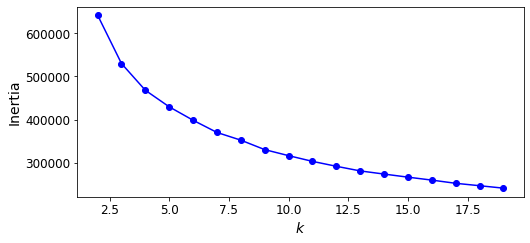

In [111]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(2, 20), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.grid(False)
plt.show()

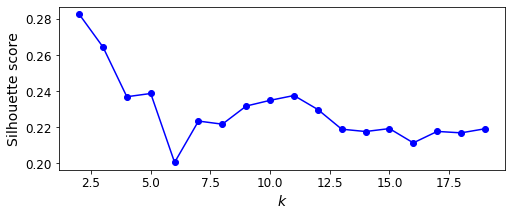

In [112]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 20), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
# plt.xlim(10,15)
# plt.ylim(0.16, 0.19)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

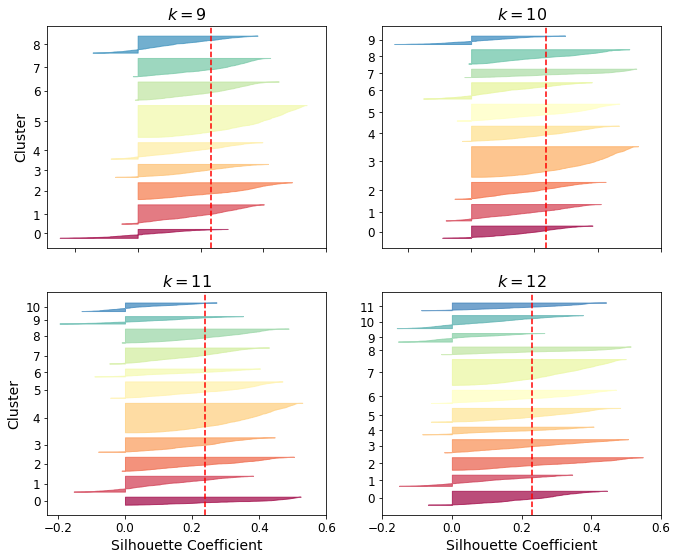

In [59]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (9, 10, 11, 12):
    plt.subplot(2, 2, k - 8)
    
    y_pred = kmeans_per_k[k - 2].labels_
    silhouette_coefficients = silhouette_samples(X_scaled, y_pred)

    padding = len(X_scaled) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos , pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (9, 11):
        plt.ylabel("Cluster")
    
    if k in (11, 12):
        
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.gca().set_xticks([-0.2, 0, 0.2, 0.4, 0.6])
    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)


plt.show()

In [37]:
len(kmeans_per_k[12 -2].cluster_centers_)
k12_centers.shape

(12, 200)

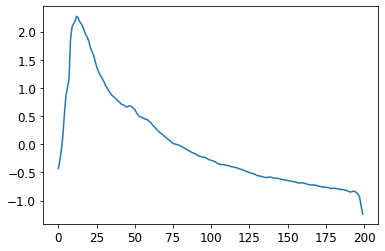

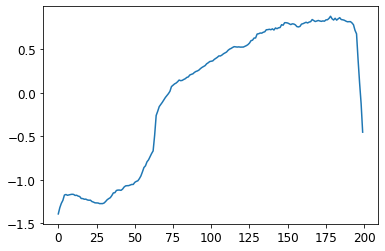

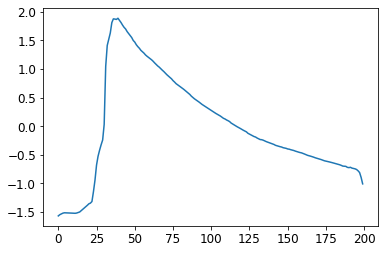

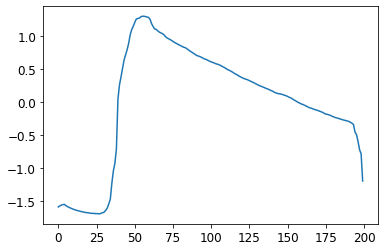

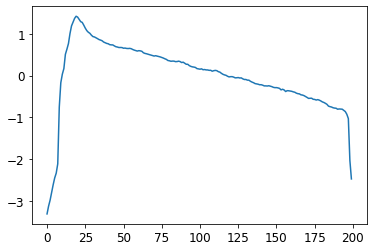

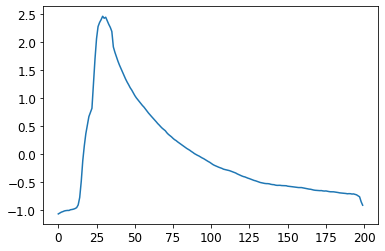

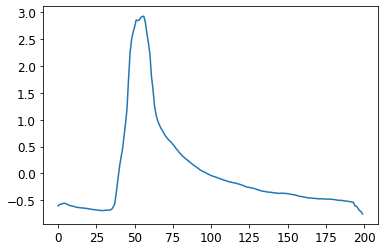

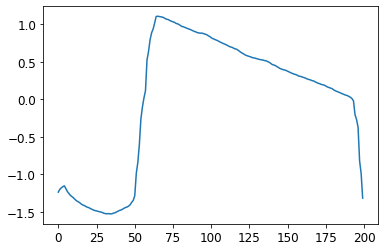

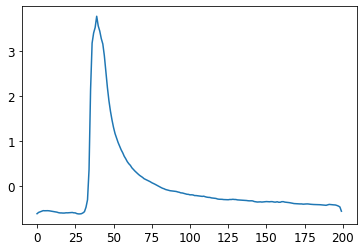

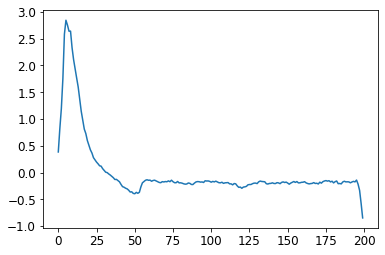

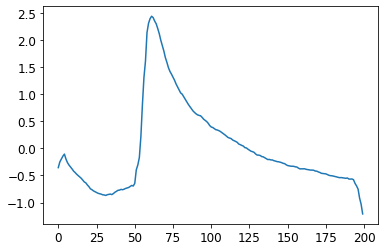

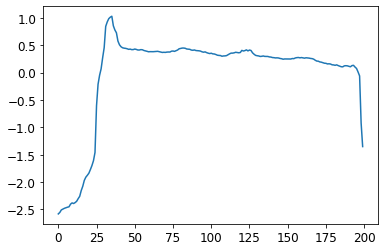

In [60]:
k12_centers = kmeans_per_k[12 -2].cluster_centers_  #np.load('data/datasets/k12_centers.npy') 
for c in k12_centers:
    plt.plot(c)
    plt.show()

In [6]:
model_dir = 'data/models/rbf'
model_version = 'rbf_001.h5'
model_csv = 'rbf_001.csv'

In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


scaler = RowScaler(scaling_method='Standard')

X_max = block_reduce(df_raw, block_size=(1, 15), func=np.max)

X_med = np.apply_along_axis(scipy.signal.medfilt,
                            axis=1,
                            arr= X_max,
                            kernel_size=9)



X_scaled = scaler.fit_transform(X_med)

kmeans = KMeans(n_clusters=150,
                algorithm='elkan',
                random_state=42,
                n_jobs=-1,
                verbose=2).fit(X_scaled)

k_centers = np.array(kmeans.cluster_centers_)
np.save('data/datasets/kmeans_centers.npy', k_centers)

In [12]:
len(k_centers)

150

In [14]:
from sklearn.metrics.pairwise import euclidean_distances
keras.backend.clear_session()

METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall')
]


d_max = np.max(euclidean_distances(k_centers, k_centers))

model = keras.models.Sequential()
model.add(keras.layers.Reshape((3000, 1), input_shape=[3000]))
model.add(keras.layers.MaxPool1D(pool_size=15, strides=15, padding='same'))

model.add(KerasPreprocess())
model.add(keras.layers.Reshape((200,)))
model.add(RBFLayer(len(k_centers),
                    initializer=InitFromFile('data/datasets/kmeans_centers.npy'),
                    betas=d_max/np.sqrt(len(k_centers)),
                    trainable=False,
                    input_shape=[200])
                    )
                    
model.add(keras.layers.Dense(1, activation='sigmoid'))

optimizer = keras.optimizers.Nadam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=METRICS)

model.summary()
model.save_weights(os.path.join(model_dir, 'rbf_weights.h5'))
# model.get_weights()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 3000, 1)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 200, 1)            0         
_________________________________________________________________
keras_preprocess (KerasPrepr (None, 200, 1)            0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 200)               0         
_________________________________________________________________
rbf_layer (RBFLayer)         (None, 150)               30150     
_________________________________________________________________
dense (Dense)                (None, 1)                 151       
Total params: 30,301
Trainable params: 151
Non-trainable params: 30,150
__________________________________________________

In [116]:
d_max

22.539446537775987

In [15]:
run_log_dir = get_run_logdir('rbf')
tensorboard_cb = keras.callbacks.TensorBoard(run_log_dir)
cv_split = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)

for index, (train_index, test_index) in enumerate(cv_split.split(X, y)):
    history = model.fit(X[train_index], y[train_index], epochs=20,
                        validation_data=(X[test_index], y[test_index]),
                        verbose=1)

Epoch 1/20
6/6 [==============================] - 1s 128ms/step - loss: 0.6932 - accuracy: 0.4217 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6933 - val_accuracy: 0.4375 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
6/6 [==============================] - 0s 38ms/step - loss: 0.6932 - accuracy: 0.4337 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6933 - val_accuracy: 0.4375 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
6/6 [==============================] - 0s 41ms/step - loss: 0.6932 - accuracy: 0.4337 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6933 - val_accuracy: 0.4375 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
6/6 [==============================] - 0s 52ms/step - loss: 0.6932 - accuracy: 0.4337 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6933 - val_accuracy: 0.4375 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
6/6 [==============================] - 0

In [89]:
print(sss)
epochs = 50
for index, (train_index, test_index) in enumerate(sss.split(X, y)):


    print('Iteration {} of {}'.format(index + 1, sss.get_n_splits()))

    X_train, X_test = tf.constant(X[train_index], dtype='float32'), tf.constant(X[test_index], dtype='float32')
    y_train, y_test = tf.constant(y[train_index], dtype='float32'), tf.constant(y[test_index], dtype='float32')

    model.load_weights(os.path.join(model_dir, 'rbf_weights.h5'))
    history = model.fit(X_train, y_train,
                        epochs=epochs, verbose=0, batch_size=32,
                        validation_data=(X_test, y_test))
    if index == 0:
        results = {item: [] for item in history.history}

    for key in history.history.keys():
        results[key].append(history.history[key][-1])

StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.33,
            train_size=None)
Iteration 1 of 10
Iteration 2 of 10
Iteration 3 of 10
Iteration 4 of 10
Iteration 5 of 10
Iteration 6 of 10
Iteration 7 of 10
Iteration 8 of 10
Iteration 9 of 10
Iteration 10 of 10


In [90]:
for key in results.keys():
    print('{} = {:.2f} +/- {:.2f}'.format(key, np.mean(results[key]), np.std(results[key])))

loss = 0.69 +/- 0.00
accuracy = 0.50 +/- 0.00
precision = 0.20 +/- 0.24
recall = 0.40 +/- 0.49
val_loss = 0.69 +/- 0.00
val_accuracy = 0.50 +/- 0.00
val_precision = 0.20 +/- 0.24
val_recall = 0.40 +/- 0.49


In [91]:
results['val_recall']

[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0]

## NN Shallow 

In [19]:
%run imports/VacuumGauge_functions.ipynb
keras.backend.clear_session()

METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall')
]

def build_DNN(units=50, metrics=METRICS):
    
    model = keras.models.Sequential()
    model.add(keras.layers.Reshape((3000, 1), input_shape=[3000]))
    model.add(keras.layers.MaxPool1D(pool_size=15, strides=15, padding='same'))
    # model.add(keras.layers.Lambda(lambda X: preprocess(X)))
    model.add(KerasPreprocess())
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(units=units, activation='relu'))
    model.add(keras.layers.Dense(units=1, activation='sigmoid'))

    # learning_rate = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.1,
    #                                                             decay_steps= batch_size ,
    #                                                             decay_rate=0.1)
    optimizer = keras.optimizers.Nadam(learning_rate=1e-5)

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=metrics)
    return model

model = build_DNN(units=50)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 3000, 1)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 200, 1)            0         
_________________________________________________________________
keras_preprocess (KerasPrepr (None, 200, 1)            0         
_________________________________________________________________
flatten (Flatten)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                10050     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 10,101
Trainable params: 10,101
Non-trainable params: 0
____________________________________________________

In [26]:
model = build_DNN(units=50)
run_log_dir = get_run_logdir('dnn')
tensorboard_cb = keras.callbacks.TensorBoard(run_log_dir)
cv_split = StratifiedShuffleSplit(n_splits=1, test_size=0.33, random_state=10)

for index, (train_index, test_index) in enumerate(cv_split.split(X, y)):
    history = model.fit(X[train_index], y[train_index], epochs=300,
                        validation_data=(X[test_index], y[test_index]),
                        verbose=1, callbacks=[tensorboard_cb])

Epoch 1/300
6/6 [==============================] - 1s 148ms/step - loss: 1.1898 - accuracy: 0.6691 - precision: 0.6044 - recall: 0.9784 - val_loss: 1.1033 - val_accuracy: 0.4891 - val_precision: 0.4945 - val_recall: 0.9783
Epoch 2/300
6/6 [==============================] - 0s 36ms/step - loss: 1.1808 - accuracy: 0.5108 - precision: 0.5056 - recall: 0.9785 - val_loss: 1.0945 - val_accuracy: 0.4891 - val_precision: 0.4945 - val_recall: 0.9783
Epoch 3/300
6/6 [==============================] - 0s 30ms/step - loss: 1.1709 - accuracy: 0.5108 - precision: 0.5056 - recall: 0.9785 - val_loss: 1.0848 - val_accuracy: 0.4891 - val_precision: 0.4945 - val_recall: 0.9783
Epoch 4/300
6/6 [==============================] - 0s 33ms/step - loss: 1.1604 - accuracy: 0.5108 - precision: 0.5056 - recall: 0.9785 - val_loss: 1.0748 - val_accuracy: 0.4891 - val_precision: 0.4945 - val_recall: 0.9783
Epoch 5/300
6/6 [==============================] - 0s 24ms/step - loss: 1.1498 - accuracy: 0.5108 - precision: 

In [21]:
model = build_DNN(units=50)
epochs = 300
run_log_dir = get_run_logdir('dnn')
tensorboard_cb = keras.callbacks.TensorBoard(run_log_dir)
#model.run_eagerly = False

print(sss)

for index, (train_index, test_index) in enumerate(sss.split(X, y)):


    print('Iteration {} of {}'.format(index + 1, sss.get_n_splits()))

    X_train, X_test = tf.constant(X[train_index], dtype='float32'), tf.constant(X[test_index], dtype='float32')
    y_train, y_test = tf.constant(y[train_index], dtype='float32'), tf.constant(y[test_index], dtype='float32')

    model = build_DNN(units=50)
    history = model.fit(X_train, y_train,
                        epochs=epochs, verbose=0, batch_size=32,
                        validation_data=(X_test, y_test))
    if index == 0:
        results = {item: [] for item in history.history}

    for key in history.history.keys():
        results[key].append(history.history[key][-1])



StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.33,
            train_size=None)
Iteration 1 of 10
Iteration 2 of 10
Iteration 3 of 10
Iteration 4 of 10
Iteration 5 of 10
Iteration 6 of 10
Iteration 7 of 10
Iteration 8 of 10
Iteration 9 of 10
Iteration 10 of 10


In [22]:
for key in results.keys():
    print('{} = {:.2f} +/- {:.2f}'.format(key, np.mean(results[key]), np.std(results[key])))

loss = 0.14 +/- 0.02
accuracy = 0.96 +/- 0.01
precision = 0.97 +/- 0.02
recall = 0.95 +/- 0.02
val_loss = 0.16 +/- 0.04
val_accuracy = 0.95 +/- 0.02
val_precision = 0.95 +/- 0.03
val_recall = 0.94 +/- 0.03


In [27]:
epochs = 300
model = build_DNN(units=50)
history = model.fit(X, y, epochs=epochs, verbose=0, batch_size=32)

In [28]:
model_dir = 'data/models/dnn'
model_version = 'dnn_001.h5'
model_csv = 'dnn_001.csv'

cv_result = pd.DataFrame(results)
cv_result.to_csv(os.path.join(model_dir, model_csv),  index=False)
model.save(os.path.join(model_dir, model_version))

In [ ]:
SVM: kernel lineare, kernel gaussiano
RBF: aumentafe i cluster a 100
Rete shallow semplice
